<a href="https://colab.research.google.com/github/Kalima83/procesamiento_lenguaje_natural_Desafios/blob/main/desafio_3V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dispositivos GPU disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tamaño vocabulario: 83
Shapes: (509929, 100) (509929, 100)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 256)       │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 1024)      │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 83)        │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 3.0548
Perplejidad: 5.58
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 533s 266ms/step - loss: 3.0548
Epoch 2/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.9605
Perplejidad: 5.47
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 533s 267ms/step - loss: 2.9605
Epoch 3/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.8943
Perplejidad: 5.09
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 532s 267ms/step - loss: 2.8943
Epoch 4/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.7984
Perplejidad: 4.99
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 533s 267ms/step - loss: 2.7984
Epoch 5/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.7006
Perplejidad: 4.78
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 534s 268ms/step - loss: 2.7005
Epoch 6/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 2.6005
Perplejidad: 4.40
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 538s 270ms/step - loss: 2.6005
Epoch 7/20
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 2.4818
Perplejidad: 3.83
1992/

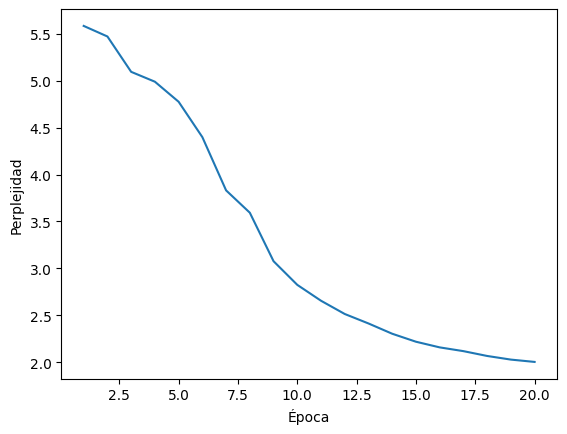


 Greedy Search:
habia una vez asie uende tebnizenoserararl s perrtono rice  edo  evos nnd coin 
eno qurcaca adir se a ebreral j cc.citaer mintststaso 
uerecas. besrtaserton eso hr  olii. seerrocospdrsa iie pbos altal codaasasuen 
ite peraar quen esaara sado nd ees aal qen ques   ro querosa en iar, esceiaac erem lullerir pe o 
r

 Muestreo con temperatura (temp=0.5):
habia una vez ssue entan untmío 
ob.í oacelella dosird rit nia nira bra nt uea nn  annarns quale pnte  
becit. poraie  aloanalastosoqlecenton demor h redo inia,ono lotallon seso feso 
qs hrabio, nsas hoes uea cr o

 Muestreo con temperatura (temp=1.5):
habia una vez adira tuenra ef vb, blo,quen osicedovc enldolcco uqid  » pes vb, ¡iíaru ceedod qestusaj lbzr  sroa qifó v8o
n n omoe adayn; jeo sa,úalrasubusa legves bil co     »bratarimoliccrecihhcslt vos hly crco 

 Beam Search determinista:
habia una vez alie prar, edo, ere a ehar 
risa erpcanral ceohon

 Beam Search estocástico (temp=1.2):
habia una vez ssie un rso sosaaqu

In [ ]:
# 1. Verificar GPU en Colab

import tensorflow as tf
print("Dispositivos GPU disponibles:", tf.config.list_physical_devices('GPU'))


# 2. Descargar y preparar texto

import urllib.request
import bs4 as bs
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences

# Descargar texto (El Conde de Montecristo)
url = 'https://www.textos.info/alejandro-dumas/el-conde-de-montecristo/ebook'
raw_html = urllib.request.urlopen(url).read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_text = ' '.join([p.text for p in article_html.find_all('p')]).lower()

# Tokenización por caracteres
chars_vocab = sorted(set(article_text))
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
tokenized_text = [char2idx[ch] for ch in article_text]

vocab_size = len(chars_vocab)
print("Tamaño vocabulario:", vocab_size)

# 3. Crear dataset reducido

max_context_size = 100
step = 5  # reduce tamaño del dataset
sequences = [tokenized_text[i:i+max_context_size] for i in range(0, len(tokenized_text)-max_context_size, step)]

X = np.array(sequences[:-1])
y = np.array(sequences[1:])
print("Shapes:", X.shape, y.shape)


# 4. Modelo optimizado para GPU (LSTM)

from tensorflow.keras.layers import Embedding, LSTM, Dense

model = keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=256, input_shape=(max_context_size,)),  # input_shape para construir el modelo
    LSTM(1024, return_sequences=True),  # sin dropout para usar kernel optimizado en GPU
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model.summary()


# 5. Callback para perplejidad (optimizado)

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, patience=3):
        self.val_data = val_data[:500]  # usar solo 500 subsecuencias para ahorrar RAM
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_data, verbose=0)
        probs = np.max(preds, axis=-1)
        ppl = np.exp(-np.mean(np.log(probs + 1e-10)))
        self.history_ppl.append(ppl)
        print(f"\nPerplejidad: {ppl:.2f}")

        if ppl < self.min_score:
            self.min_score = ppl
            self.model.save("best_model.keras")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("Early stopping...")
                self.model.stop_training = True


# 6. Entrenamiento en GPU

history_ppl = []
val_subset = X[:1000]  # pequeño subset para validación
model.fit(X, y, epochs=20, batch_size=256, callbacks=[PplCallback(val_subset, history_ppl)])  # batch grande para GPU


# 7. Visualizar perplejidad

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.show()


# 8. Cargar mejor modelo

model = keras.models.load_model("best_model.keras")


# 9. Generación de texto (Greedy)

def generate_text(seed_text, n_chars=200):
    output = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output[-max_context_size:]]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')
        pred = model.predict(encoded, verbose=0)[0, -1, :]
        next_char = idx2char[np.argmax(pred)]
        output += next_char
    return output

print("\n Greedy Search:")
print(generate_text("habia una vez", n_chars=300))


# 10. Muestreo con temperatura

def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_with_temperature(seed_text, n_chars=200, temperature=1.0):
    output = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output[-max_context_size:]]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')
        preds = model.predict(encoded, verbose=0)[0, -1, :]
        next_idx = sample_with_temperature(preds, temperature)
        output += idx2char[next_idx]
    return output

print("\n Muestreo con temperatura (temp=0.5):")
print(generate_with_temperature("habia una vez", n_chars=200, temperature=0.5))

print("\n Muestreo con temperatura (temp=1.5):")
print(generate_with_temperature("habia una vez", n_chars=200, temperature=1.5))


# 11. Beam Search (determinista y estocástico)

from scipy.special import softmax

def encode(text):
    encoded = [char2idx[ch] for ch in text]
    return pad_sequences([encoded], maxlen=max_context_size, padding='pre')

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []
    for idx, pp in enumerate(preds):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])
    pred_large = np.array(pred_large)

    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large / temp))
    else:
        raise ValueError("Modo incorrecto. Usa 'det' o 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, num_beams, num_chars, input_text, temp=1.0, mode='det'):
    encoded = encode(input_text)
    y_hat = model.predict(encoded, verbose=0)[0, -1, :]
    vocab_size = y_hat.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams

    history_probs, history_tokens = select_candidates([y_hat], num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    for i in range(num_chars - 1):
        preds = []
        for hist in history_tokens:
            input_update = np.array([hist[i+1:]]).copy()
            y_hat = model.predict(input_update, verbose=0)[0, -1, :]
            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    return history_tokens[:, -(len(input_text) + num_chars):]

print("\n Beam Search determinista:")
salidas_det = beam_search(model, num_beams=5, num_chars=50, input_text="habia una vez", mode='det')
print(decode(salidas_det[0]))

print("\n Beam Search estocástico (temp=1.2):")
salidas_sto = beam_search(model, num_beams=5, num_chars=50, input_text="habia una vez", temp=1.2, mode='sto')
print(decode(salidas_sto[0]))


 ## 1. Configuración del modelo

Tu modelo es un LSTM clásico de lenguaje con:

Embedding: 64 dims

LSTM: 256 unidades

Dense final con vocabulario de 83 tokens

Total: 355k parámetros (bastante pequeño)

Secuencias: 100 tokens
Dataset: ~510k ejemplos

Model: "sequential_1"

 Total params: 355,347 (1.36 MB)

 Trainable params: 355,347 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 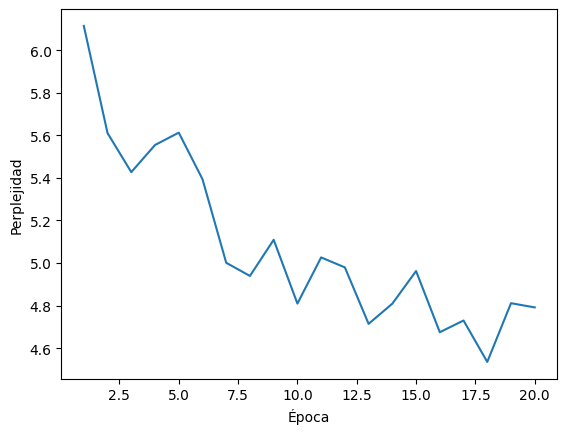


1. Greedy Search:
habia una vez a e o  ee  ia a r er ro er  ee  ia aaaare  ee  ia aaaare  ee  ia aara uee a a rr  eoo o   eao  rte  e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,osrae   e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,osrae   r ene  e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,os

2. Muestreo con temperatura (temp=0.5):
habia una vezl a a r enes   ao oc?c!   t uneeue uueante dsa ie edo  eoo o sra er uee ieaarei uee uu n o  iae ni i
ddee a  ra eie  edo,on aear sso  o a iae lee ee d uen neo  et
 ros au o   a e oo  itnae uilsi  tso

3. Muestreo con temperatura (temp=1.5):
habia una vezleer¿jc—ecod,o!d   !c,eavr dgs,mdr  oie o uvi s brcbo noo,yr!qt punee
azour ­oencphi edc rdeauála lstn,lé nr d ep  r h­,
pr,ergd­dounjunmneunupaíesóaanm!psnórm bii mf sfo—blly mu,ee p
 psaqj j tunca c

4. Beam Search determinista:
habia una vez a r eia!  ee d nt oee d rt, aeame e rta ueed uee

5. Beam Search estocástico (temp=1.2):
habia una vez
aiedeu qes oooo! o rz de t oo e e nt neta  uoot  

### Conclusión: calidad del texto generado

1. Greedy Search

Produce texto incoherente, lleno de repeticiones y vocales sueltas.

2. Sampling (temp 0.5)
Mejora un poco, pero sigue con palabras rotas.
Falta estructura sintáctica.

3. Sampling (temp 1.5)
Mucho ruido, caracteres aleatorios.
Muestra que el modelo no captura bien dependencias a largo plazo.

4. Beam Search
Algo más estructurado, pero sigue generando basura lingüística.